In [2]:
using SparseArrays
using LinearAlgebra
using NLopt
using PyPlot
using KrylovKit
using Statistics
using FiniteDifferences
using Revise
using IJulia
using Plots
using Images
using TopologyOptimizationHelper

┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API C:\Users\jorge\.julia\juliaup\julia-1.10.4+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\API.jl:1807
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
GKS: cairoplugin.dll: can't load library, error 126 (0x7e)
┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API C:\Users\jorge\.julia\juliaup\julia-1.10.4+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\API.jl:1807
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.

In [3]:
Lx = 5
Ly = 5
res = 20
ε = ones(res * (Ly + 1), res * (Lx + 1))
ω = 2π
@show offset = -round(Int, res * (0.1 + 3/2))
N, M = size(ε)
b = zeros(N, M)
b[N÷2 + offset, M÷2] = 1;

offset = -(round(Int, res * (0.1 + 3 / 2))) = -32


In [4]:
function LDOS_Optimize2d(Lx, Ly, ε, ω, b; dpml=0.5, resolution=20, Rpml=1e-20, ftol=1e-4, max_eval=500, design_dimensions=(Lx, Ly), α=0)
    A, x, y = Maxwell2d(Lx, Ly, ε, ω; dpml, resolution, Rpml)
    ε = vec(ε)
    b = vec(b)
    D² = A + spdiagm(ω^2 .* ε)
    M, N = length(x), length(y)
    LDOS_vals = Float64[]
    omegas = ComplexF64[]
    
    function LDOS_obj(ε, grad)
        ε = vec(ε)
        A = D² - spdiagm(ω^2 .* ε .* (1 + α * im))
        LDOS, ∇LDOS = ∇_ε_LDOS(A, ω, b; α)
        grad .= ∇LDOS
        push!(LDOS_vals, LDOS)

        IJulia.clear_output(true)  # Clear notebook output
        plt.clf()  # Clear the current figure, removes all previous plots
        
        figure(figsize=(6, 6))  # Fix the figure size to avoid shrinking
        imshow(reshape(ε, N,M), cmap="coolwarm", vmin=1, vmax=12)
        title("Iteration $(length(LDOS_vals)), LDOS = $LDOS")
        colorbar(label=L"ε_{opt}")

        display(gcf())  # Display the current figure in the notebook
        sleep(0.1)  # Pause to visualize the update

        A_now, _, _ = Maxwell2d(Lx, Ly, reshape(ε, N,M), ω; resolution=res)
        ω₀_now = sqrt(Arnoldi_eig(A_now, vec(ε), ω, vec(b))[1])
        push!(omegas, ω₀_now)
        return LDOS
    end

    design_x, design_y = design_dimensions
    x_indices = -design_x / 2 .< x .- mean(x) .< design_x / 2
    y_indices = -design_y / 2 .< y .- mean(y) .< design_y / 2
    ub = ones(N,M)
    ub[y_indices, x_indices] .= 12
    ub = vec(ub)
    
    opt = Opt(:LD_CCSAQ, M * N)
    opt.lower_bounds = 1
    opt.upper_bounds = ub
    opt.ftol_rel = ftol
    opt.maxeval = max_eval
    opt.max_objective = LDOS_obj

    (LDOS_opt, ε_opt, ret) = optimize(opt, ε)
    A_opt, _, _ = Maxwell2d(Lx, Ly, ε_opt, ω; resolution=res)
    ω₀_opt = sqrt(Arnoldi_eig(A_opt, vec(ε_opt), ω, vec(b))[1])
    Q_opt = -real(ω₀_opt) / 2imag(ω₀_opt)
    
    IJulia.clear_output(true)  # Clear notebook output
    plt.clf()  # Clear the current figure, removes all previous plots

    @show numevals = opt.numevals # the number of function evaluations
    @show ω₀_opt
    @show Q_opt
    
    return LDOS_opt, reshape(ε_opt, N,M), LDOS_vals, omegas, x, y
end

LDOS_Optimize2d (generic function with 1 method)

In [5]:
function mod_LDOS_Optimize2d(Lx, Ly, ε, ω, b, x₀; dpml=0.5, resolution=20, Rpml=1e-20, ftol=1e-4, max_eval=500, design_dimensions=(Lx,Ly))
    A, x, y = Maxwell2d(Lx, Ly, ε, ω; dpml, resolution, Rpml)
    ε = vec(ε)
    b = vec(b)
    D² = A + ω^2 .* spdiagm(ε)
    M, N = length(x), length(y)
    mod_LDOS_vals = Float64[]
    mod_omegas = ComplexF64[]
    ω_old = ω
    u_old = ones(M * N)
    LDOS_old = ∇_ε_LDOS(A, ω, vec(b))[1]
    
    function mod_LDOS_obj(ε, grad)
        ε = vec(ε)
        E = spdiagm(ε)
        A = D² - real(ω_old)^2 .* E
        E⁻¹ = spdiagm(1 ./ ε)
        C = E⁻¹ * A
        LU = lu(C)
        vals, vecs, _ = eigsolve(z -> LU \ z, x₀, 1, :LM, Arnoldi())
        vals = sqrt.(1 ./ vals .+ real(ω_old)^2)
        # We could also just have * done here every time
        # Pros: outperforms old scheme (and this one)
        # Cons: monotonically decreases on some intervals
        ω₀, u₀ = vals[1], vecs[1]
        A₀ = D² - real(ω₀)^2 .* E
        v = A₀ \ b
        w = A₀' \ b
        LDOS = -imag(v' * b)
        
        reals = real.(vals)
        imaginaries = imag.(vals)
        if !isempty(grad) 
            ∂LDOS_∂ε = -imag.(real(ω₀)^2 .* conj.(v) .* w)
            ∂LDOS_∂ω = -imag(2real(ω₀) .* v' * E * w)
            ∂ω_∂ε = -ω₀ .* u₀.^2 ./ 2sum(u₀.^2 .* ε)
            ∇LDOS = ∂LDOS_∂ε .+  ∂LDOS_∂ω .* real.(∂ω_∂ε)

            grad .= ∇LDOS
        end

        push!(mod_LDOS_vals, LDOS)
        push!(mod_omegas, ω₀)

        IJulia.clear_output(true)  # Clear notebook output
        plt.clf()  # Clear the current figure, removes all previous plots
        
        fig, ax = plt.subplots(1,2, figsize=(15, 5))  # Fix the figure size to avoid shrinking
        ε_graph = ax[1].imshow(reshape(ε, N,M), cmap="coolwarm", vmin=1, vmax=12)
        ax[1].set_title("Iteration $(length(mod_LDOS_vals)), LDOS = $LDOS")
        plt.colorbar(ε_graph, label=L"ε_{opt}", ax=ax[1])

        ax[2].scatter(reals[2:end], imaginaries[2:end], color="blue")
        ax[2].scatter(reals[1], imaginaries[1], color="red")
        ax[2].scatter(real(ω_old), imag(ω_old), color="green")
        ax[2].set_xlim(6,6.5)
        ax[2].set_ylim(-0.5, 0.01)

        display(gcf())  # Display the current figure in the notebook
        sleep(0.1)  # Pause to visualize the update

        return LDOS
    end

    function freq_constraint(ε, grad)
        ω₀, ∂ω_∂ε = Eigengradient(A, ε, ω, x₀)
        if !isempty(grad) 
            grad .= -real.(∂ω_∂ε)
        end

        return ω - real(ω₀)
    end

    design_x, design_y = design_dimensions
    x_indices = -design_x / 2 .< x .- mean(x) .< design_x / 2
    y_indices = -design_y / 2 .< y .- mean(y) .< design_y / 2
    ub = ones(N,M)
    ub[y_indices, x_indices] .= 12
    ub = vec(ub)
    
    opt = Opt(:LD_CCSAQ, M * N)
    # opt.params["verbosity"] = 1
    opt.lower_bounds = 1
    opt.upper_bounds = ub
    opt.ftol_rel = ftol
    opt.maxeval = max_eval
    opt.max_objective = mod_LDOS_obj
    opt.initial_step = 1e-3
    inequality_constraint!(opt, freq_constraint)

    (mod_LDOS_opt, mod_ε_opt, ret) = optimize(opt, ε)
    A_opt, _, _ = Maxwell2d(Lx, Ly, mod_ε_opt, ω; resolution=res)
    ω₀_opt = sqrt(Arnoldi_eig(A_opt, vec(mod_ε_opt), ω, vec(b))[1])
    Q_opt = -real(ω₀_opt) / 2imag(ω₀_opt)
    
    IJulia.clear_output(true)  # Clear notebook output
    plt.clf()

    @show numevals = opt.numevals # the number of function evaluations
    @show ω₀_opt
    @show Q_opt
    
    return mod_LDOS_opt, reshape(mod_ε_opt, N,M), mod_LDOS_vals, mod_omegas, x, y
end

mod_LDOS_Optimize2d (generic function with 1 method)

In [6]:
function ring_resonator(X, inner, outer; resolution=20)
    # Get matrix dimensions
    N, M = size(X)
    
    # Compute the center of the matrix
    center_y = N÷2
    center_x = M÷2
    
    # Assign value to entries within the given radii
    for i in 1:M
        for j in 1:N
            # Calculate the distance from the center, considering the resolution
            square_dist = ((i - center_x) / res)^2 + ((j - center_y) / res)^2
            if inner^2 <= square_dist <= outer^2
                X[j, i] = 12
            end
        end
    end
    return X
end

ring_resonator (generic function with 1 method)

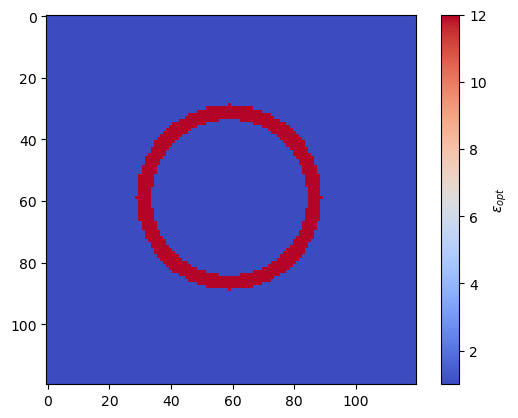

PyObject <matplotlib.colorbar.Colorbar object at 0x0000020A94F16AD0>

In [71]:
design_ring = ring_resonator(ones(N,M), 1.258984375, 1.5; resolution=res)
imshow(design_ring, cmap="coolwarm", vmin=1, vmax=12)
colorbar(label=L"ε_{opt}")

In [72]:
A_resonator, x, y = Maxwell2d(Lx, Ly, design_ring, ω; resolution=res)
ring_ω₀, _ = Eigengradient(A_resonator, vec(design_ring), ω, ones(N * M))
@show ring_ω₀

ring_ω₀ = 6.260137693507353 - 8.175207780221053e-5im


6.260137693507353 - 8.175207780221053e-5im

In [73]:
w_ring = A_resonator' \ vec(b)
@show ring_LDOS = -imag(vec(b)' * w_ring)
ring_Q = -real(ring_ω₀) / 2imag(ring_ω₀)

ring_LDOS = -(imag((vec(b))' * w_ring)) = 0.0002955231089506742


38287.330804319216

In [9]:
_, ε_opt_naive, LDOS_vals_naive, omegas_naive, _, _ = LDOS_Optimize2d(Lx, Ly, design_ring, ω, b; resolution=res, max_eval=15000, ftol=0, α=0, design_dimensions=(3.05,3.05))

numevals = opt.numevals = 15000
ω₀_opt = 6.283185307371432 - 2.483093229702217e-8im
Q_opt = 1.2651931937579602e8


(43.44549456859786, [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], [0.002567003838891125, 0.0003941275660668207, 0.00040257171279745475, 0.00040263398192443565, 0.00039782465350839575, 0.0003956052191277254, 0.0004961527520605191, 0.003385430358901667, 0.0024710113430788656, 0.01320978980225005  …  43.435545984422006, 43.43250275908933, 43.436916655009995, 43.333405506041, 43.43768912315155, 43.43857593976567, 43.439278255403174, 43.44549456859786, 24.589276417523628, 43.16460375049924], ComplexF64[6.282980445149519 - 8.327062568689475e-5im, 6.280010093858054 - 0.004782509507351119im, 6.269618111472296 - 0.004705791012818489im, 6.293240554771614 - 9.106422313870752e-5im, 6.287581298217694 - 8.656788389314073e-5im, 6.28501268733561 - 8.469182844373339e-5im, 6.283847692085917 - 8.387055171907802e-5im, 6.2833246506526 - 8.35075813656385e-5im, 6.2829743423312685 - 8.331179295146698e-5im, 6.283176556610118 - 8.345857713179442e-5im  …  6.283185307173755 - 2

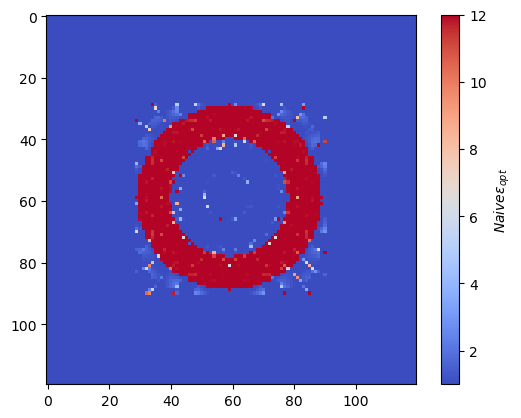

PyObject <matplotlib.colorbar.Colorbar object at 0x000001ACB3FC9B10>

In [10]:
imshow(ε_opt_naive, cmap="coolwarm", vmin=1, vmax=12)
colorbar(label=L"Naive ε_{opt}")

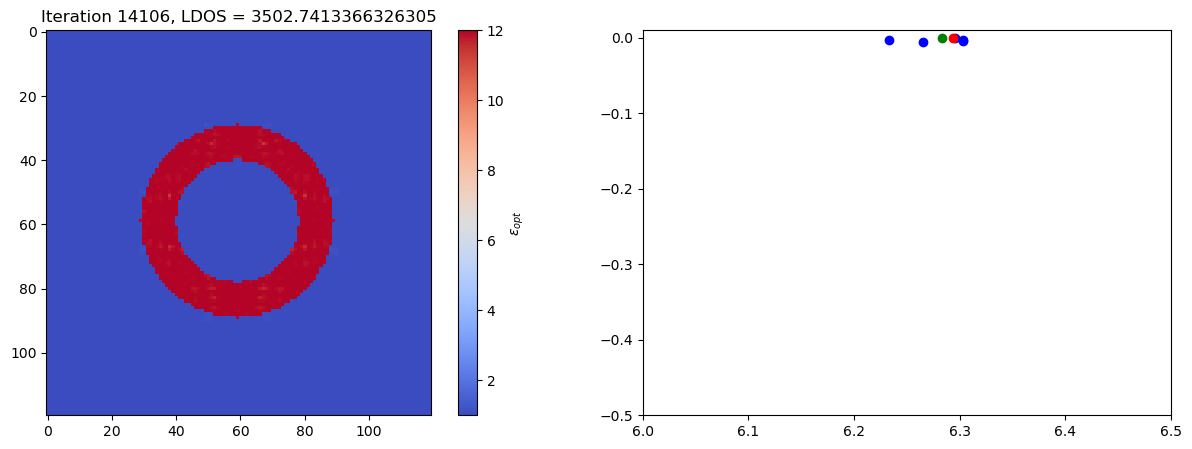

In [ ]:
_, ε_opt_mod, LDOS_vals_mod, omegas_mod, _, _ = mod_LDOS_Optimize2d(Lx, Ly, design_ring, ω, b, vec(b); resolution=res, max_eval=15000, ftol=0, design_dimensions=(3.05,3.05))

In [ ]:
imshow(ε_opt_mod, cmap="coolwarm", vmin=1, vmax=12)
colorbar(label=L"Mod ε_{opt} (3,000 iterations)")

In [ ]:
#LDOS plots

plot(LDOS_vals_naive, color="red")
plot(LDOS_vals_mod, color="blue")

In [ ]:
#Q plots
naive_Qs = -real.(omegas_naive) ./ 2imag.(omegas_naive)
mod_Qs = -real.(omegas_mod) ./ 2imag.(omegas_mod)

plot(naive_Qs, color="red")
plot(mod_Qs, color="blue")